In [21]:
from sklearn.metrics import auc, roc_curve

In [22]:
from UNet import UNetModel, update_ema_params

In [23]:
import collections
import copy
import sys
import time
from random import seed

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from torch import optim

import dataset
import evaluation
from GaussianDiffusion import GaussianDiffusionModel, get_beta_schedule
from helpers import *
from UNet import UNetModel, update_ema_params
import random
torch.cuda.empty_cache()


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
args, output = load_parameters(device)

['.ipynb_checkpoints', 'diff-params-ARGS=', 'diff-params-ARGS=10', 'diff-params-ARGS=12', 'diff-params-ARGS=14', 'diff-params-ARGS=26', 'diff-params-ARGS=27', 'diff-params-ARGS=28', 'diff-params-ARGS=30', 'diff-params-ARGS=31', 'diff-params-ARGS=32', 'diff-params-ARGS=33', 'diff-params-ARGS=34', 'diff-params-ARGS=35', 'diff-params-ARGS=36']


In [26]:
# betas.shape

In [27]:
args, output = load_parameters(device)

print(f"args{args['arg_num']}")
unet = UNetModel(args['img_size'][0], args['base_channels'], channel_mults=args['channel_mults'], in_channels=args["channels"])

betas = get_beta_schedule(args['T'], args['beta_schedule'])

diff = GaussianDiffusionModel(
        args['img_size'], betas, loss_weight=args['loss_weight'],
        loss_type=args['loss-type'], noise=args["noise_fn"], img_channels = args["channels"]
        )

unet.load_state_dict(output["ema"])
unet.to(device)
unet.eval()
ROOT_DIR = "./"
training_dataset, ano_dataset = dataset.init_datasets(ROOT_DIR, args)
loader = dataset.init_dataset_loader(ano_dataset, args)
# plt.rcParams['figure.dpi'] = 200

try:
    os.makedirs(f'./diffusion-videos/ARGS={args["arg_num"]}/Anomalous')
except OSError:
    pass

# make folder for each anomalous volume
#     for i in ano_dataset.slices.keys():
try:
    os.makedirs(f'./diffusion-videos/ARGS={args["arg_num"]}/Anomalous')
except OSError:
    pass

dice_data = []
start_time = time.time()

['.ipynb_checkpoints', 'diff-params-ARGS=', 'diff-params-ARGS=10', 'diff-params-ARGS=12', 'diff-params-ARGS=14', 'diff-params-ARGS=26', 'diff-params-ARGS=27', 'diff-params-ARGS=28', 'diff-params-ARGS=30', 'diff-params-ARGS=31', 'diff-params-ARGS=32', 'diff-params-ARGS=33', 'diff-params-ARGS=34', 'diff-params-ARGS=35', 'diff-params-ARGS=36']
args35


In [28]:
image_path = r"C:\Users\Admin\Dropbox\PC\Documents\Anomaly Detection\AnoDDPM\DATASETS\CheNemonia\chest_xray\train\PNEUMONIA\person1944_bacteria_4869.jpeg"

In [29]:
input_size = 256

In [30]:
import imageio
from PIL import Image
from torchvision import transforms

C:\Users\Admin\AppData\Local\Temp\ipykernel_21140\3410104909.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_path)


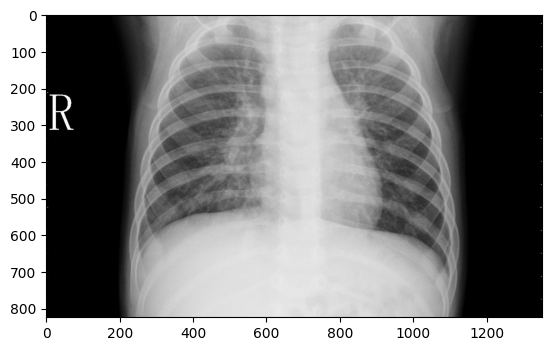

In [88]:
img = imageio.imread(image_path)
if len(img.shape) == 2:
    img = np.stack([img] * 3, 2)
img = Image.fromarray(img, mode='RGB')
plt.imshow(img)
# img = transforms.Resize((input_size, input_size))(img)
# img = transforms.RandomResizedCrop(size=input_size, scale=(0.4, 0.75), ratio=(0.5,1.5))(img)
# img = transforms.RandomCrop(input_size)(img)
# img = transforms.RandomHorizontalFlip()(img)
# img = transforms.ColorJitter(brightness=0.2, contrast=0.2)(img)

img = transforms.ToTensor()(img)
img = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)
mask = torch.zeros(3, input_size, input_size)
#             img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
sample = {'image': img.unsqueeze(0), "mask":mask}

In [89]:
# dataset_loader = torch.utils.data.DataLoader(sample, batch_size=args['Batch_Size'], shuffle=True)

In [90]:
# new = iter(dataset_loader)

In [91]:
# sample["image"].shape

In [93]:
img.shape

torch.Size([3, 824, 1352])

In [97]:
plt.imshow(img.reshape(824, 1352, 3).astype("uint8"))

AttributeError: 'Tensor' object has no attribute 'astype'

In [70]:
# for i in range(len(ano_dataset)):
new = sample

img = new["image"].to(device)

img_mask = new["mask"]

img_mask = transforms.Resize((256, 256))(img_mask)

img_mask = img_mask.to(device)

if args["noise_fn"] == "gauss":
    timestep = random.randint(int(args["sample_distance"] * 0.3), int(args["sample_distance"] * 0.8))
else:
    timestep = random.randint(int(args["sample_distance"] * 0.7), int(args["sample_distance"] * 0.8))



In [71]:
timestep = 800

In [18]:
output = diff.forward_backward(
        unet, img.reshape(1, args["channels"], *args["img_size"]),
        see_whole_sequence=None,
        t_distance=timestep, denoise_fn=args["noise_fn"]
        )

KeyboardInterrupt: 

In [98]:
output = output.reshape(256, 256, 3)

AttributeError: 'dict' object has no attribute 'reshape'

In [ ]:
plt.imshow(img.cpu().reshape(256, 256, 3))

In [ ]:
plt.imshow(output.cpu())

In [1]:
import torch

def dice_score(preds, targets):
    intersection = torch.sum(preds * targets)
    union = torch.sum(preds) + torch.sum(targets)
    dice = (2 * intersection) / (union + 1e-8)  # Adding a small constant to avoid division by zero
    return dice

# Example usage
predicted_mask = torch.tensor([[[[0, 1], [1, 0]], [[1, 0], [0, 1]]]])
target_mask = torch.tensor([[[[0, 1], [1, 1]], [[1, 1], [0, 1]]]])

dice = dice_score(predicted_mask, target_mask)
print("Dice Score:", dice.item())


Dice Score: 0.800000011920929


In [2]:
dice

tensor(0.8000)

In [6]:
import numpy as np

In [21]:
t_range = np.linspace(100, 1000, 100).astype(np.int32)

In [22]:
t_range

array([ 100,  109,  118,  127,  136,  145,  154,  163,  172,  181,  190,
        200,  209,  218,  227,  236,  245,  254,  263,  272,  281,  290,
        300,  309,  318,  327,  336,  345,  354,  363,  372,  381,  390,
        400,  409,  418,  427,  436,  445,  454,  463,  472,  481,  490,
        500,  509,  518,  527,  536,  545,  554,  563,  572,  581,  590,
        600,  609,  618,  627,  636,  645,  654,  663,  672,  681,  690,
        700,  709,  718,  727,  736,  745,  754,  763,  772,  781,  790,
        800,  809,  818,  827,  836,  845,  854,  863,  872,  881,  890,
        900,  909,  918,  927,  936,  945,  954,  963,  972,  981,  990,
       1000])